In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    precision_recall_curve
)

from xgboost import XGBClassifier

In [3]:
data = pd.read_csv('ncr_ride_bookings.csv', header=None, low_memory=False)
print(data.head(10))

           0         1             2                3             4   \
0        Date      Time    Booking ID   Booking Status   Customer ID   
1  2024-03-23  12:29:38  "CNR5884300"  No Driver Found  "CID1982111"   
2  2024-11-29  18:01:39  "CNR1326809"       Incomplete  "CID4604802"   
3  2024-08-23  08:56:10  "CNR8494506"        Completed  "CID9202816"   
4  2024-10-21  17:17:25  "CNR8906825"        Completed  "CID2610914"   
5  2024-09-16  22:08:00  "CNR1950162"        Completed  "CID9933542"   
6  2024-02-06  09:44:56  "CNR4096693"        Completed  "CID4670564"   
7  2024-06-17  15:45:58  "CNR2002539"        Completed  "CID6800553"   
8  2024-03-19  17:37:37  "CNR6568000"        Completed  "CID8610436"   
9  2024-09-14  12:49:09  "CNR4510807"  No Driver Found  "CID7873618"   

              5                    6                  7         8         9   \
0   Vehicle Type      Pickup Location      Drop Location  Avg VTAT  Avg CTAT   
1          eBike          Palam Vihar          

Dataset Shape: (150000, 21)

First 5 rows:
         Date      Time    Booking ID   Booking Status   Customer ID  \
0  2024-03-23  12:29:38  "CNR5884300"  No Driver Found  "CID1982111"   
1  2024-11-29  18:01:39  "CNR1326809"       Incomplete  "CID4604802"   
2  2024-08-23  08:56:10  "CNR8494506"        Completed  "CID9202816"   
3  2024-10-21  17:17:25  "CNR8906825"        Completed  "CID2610914"   
4  2024-09-16  22:08:00  "CNR1950162"        Completed  "CID9933542"   

    Vehicle Type      Pickup Location      Drop Location  Avg VTAT  Avg CTAT  \
0          eBike          Palam Vihar            Jhilmil       NaN       NaN   
1       Go Sedan        Shastri Nagar  Gurgaon Sector 56       4.9      14.0   
2           Auto              Khandsa      Malviya Nagar      13.4      25.8   
3  Premier Sedan  Central Secretariat           Inderlok      13.1      28.5   
4           Bike     Ghitorni Village        Khan Market       5.3      19.6   

   ...  Reason for cancelling by Customer C

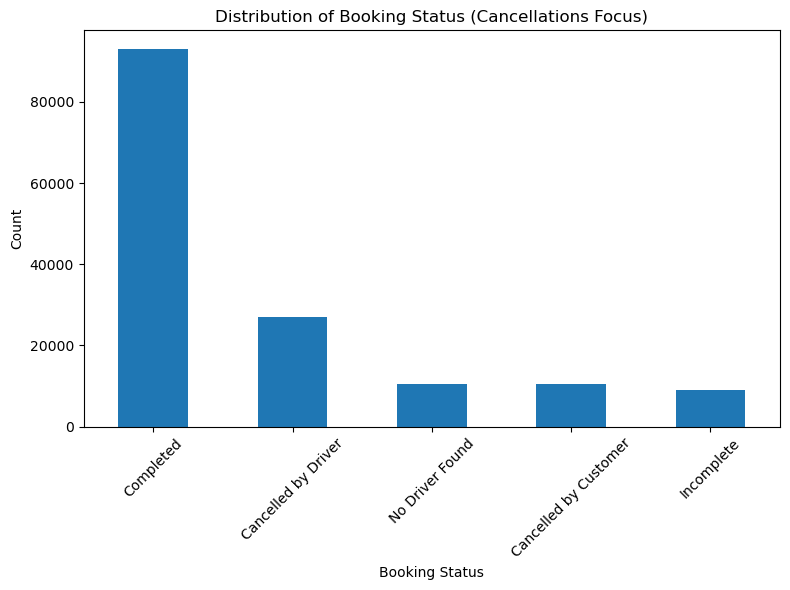


=== Summary of Cancellation Reasons ===

Reason for cancelling by Customer:
Reason for cancelling by Customer
Wrong Address                                   2362
Change of plans                                 2353
Driver is not moving towards pickup location    2335
Driver asked to cancel                          2295
AC is not working                               1155
Name: count, dtype: int64

Cancelled Rides by Driver:
Cancelled Rides by Driver
1.0    27000
Name: count, dtype: int64

Driver Cancellation Reason:
Driver Cancellation Reason
Customer related issue                 6837
The customer was coughing/sick         6751
Personal & Car related issues          6726
More than permitted people in there    6686
Name: count, dtype: int64

Incomplete Rides:
Incomplete Rides
1.0    9000
Name: count, dtype: int64

Incomplete Rides Reason:
Incomplete Rides Reason
Customer Demand      3040
Vehicle Breakdown    3012
Other Issue          2948
Name: count, dtype: int64

=== Handling NaN i

In [4]:
df = pd.read_csv('ncr_ride_bookings.csv')

# Display basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Step 1: Descriptive Analysis
# Overall descriptive statistics for numerical columns
print("\n=== Descriptive Statistics (Numerical Columns) ===")
print(df.describe())

# Focus on cancellation-related aspects
# Assuming 'Booking Status' indicates cancellations (e.g., 'No Driver Found', 'Incomplete' vs 'Completed')
print("\n=== Descriptive Analysis for Cancellations ===")
cancellation_summary = df['Booking Status'].value_counts()
print("Booking Status Distribution:")
print(cancellation_summary)

# Group by Booking Status for key metrics (e.g., Avg VTAT, Avg CTAT, Ride Distance, Booking Value)
status_groups = df.groupby('Booking Status').agg({
    'Avg VTAT': ['mean', 'median', 'count'],
    'Avg CTAT': ['mean', 'median', 'count'],
    'Ride Distance': ['mean', 'median'],
    'Booking Value': ['mean', 'median'],
    'Customer ID': 'count'  # Total rides per status
}).round(2)
print("\nMetrics by Booking Status:")
print(status_groups)

# Visualize Booking Status distribution
plt.figure(figsize=(8, 6))
cancellation_summary.plot(kind='bar')
plt.title('Distribution of Booking Status (Cancellations Focus)')
plt.xlabel('Booking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional: Cancellation reasons (if applicable)
# Check for cancellation-related columns
cancel_cols = ['Reason for cancelling by Customer', 'Cancelled Rides by Driver', 
               'Driver Cancellation Reason', 'Incomplete Rides', 'Incomplete Rides Reason']
print("\n=== Summary of Cancellation Reasons ===")
for col in cancel_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().head(10))  # Top 10 values
    else:
        print(f"\n{col}: Column not found")

for col in ["Avg VTAT", "Avg CTAT"]:
    print(f"\n=== Handling NaN in {col} ===")
    print(f"NaN count before: {df[col].isnull().sum()}")

    mean_val = df[col].mean()
    print(f"Mean of {col}: {mean_val:.2f}")

    df[col] = df[col].fillna(mean_val)

    print(f"NaN count after: {df[col].isnull().sum()}")

In [5]:
df['Is_Cancelled'] = ((df['Booking Status'] != 'Completed') | 
                      (df['Incomplete Rides'].fillna(0) > 0)).astype(int)
print("\nCancellation Target Distribution:")
print(df['Is_Cancelled'].value_counts())


Cancellation Target Distribution:
Is_Cancelled
0    93000
1    57000
Name: count, dtype: int64


In [6]:
print("\n=== Feature Engineering: Date and Time ===")
# Combine Date and Time into datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Datetime'].dt.month
df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)  # 1 if weekend
df['Is_Peak_Hour'] = (((df['Hour'] >= 7) & (df['Hour'] <= 9)) | ((df['Hour'] >= 17) & (df['Hour'] <= 20))).astype(int)  # Rough peak hours

print("New Date/Time features added:")
print(df[['Hour', 'DayOfWeek', 'Month', 'Is_Weekend', 'Is_Peak_Hour']].head())
print(f"\nDate range: {df['Datetime'].min()} to {df['Datetime'].max()}")

print("\n=== Feature Engineering: Locations ===")
print(f"Unique Pickup Locations: {df['Pickup Location'].nunique()}")
print(f"Unique Drop Locations: {df['Drop Location'].nunique()}")


=== Feature Engineering: Date and Time ===
New Date/Time features added:
   Hour  DayOfWeek  Month  Is_Weekend  Is_Peak_Hour
0    12          5      3           1             0
1    18          4     11           0             1
2     8          4      8           0             1
3    17          0     10           0             1
4    22          0      9           0             0

Date range: 2024-01-01 00:19:34 to 2024-12-30 23:36:11

=== Feature Engineering: Locations ===
Unique Pickup Locations: 176
Unique Drop Locations: 176


In [7]:
pickup_freq = df['Pickup Location'].value_counts().to_dict()
drop_freq = df['Drop Location'].value_counts().to_dict()
df['Pickup_Freq'] = df['Pickup Location'].map(pickup_freq)
df['Drop_Freq'] = df['Drop Location'].map(drop_freq)

le_pickup = LabelEncoder()
le_drop = LabelEncoder()
df['Pickup_Encoded'] = le_pickup.fit_transform(df['Pickup Location'])
df['Drop_Encoded'] = le_drop.fit_transform(df['Drop Location'])

top_n = 10
top_pickups = df['Pickup Location'].value_counts().head(top_n).index
top_drops = df['Drop Location'].value_counts().head(top_n).index
print(f"Top {top_n} pickups: {list(top_pickups)}")
print(f"Top {top_n} drops: {list(top_drops)}")

pickup_dummies = pd.get_dummies(df['Pickup Location'], prefix='Pickup').reindex(columns=[f'Pickup_{loc}' for loc in top_pickups], fill_value=0).astype(int)
drop_dummies = pd.get_dummies(df['Drop Location'], prefix='Drop').reindex(columns=[f'Drop_{loc}' for loc in top_drops], fill_value=0).astype(int)

df = pd.concat([df, pickup_dummies, drop_dummies], axis=1)

print("Sample Location Features:")
print(df[['Pickup_Freq', 'Drop_Freq', 'Pickup_Encoded', 'Drop_Encoded']].head())
print(f"\nTop {top_n} Pickup Dummies shape: {pickup_dummies.shape}")
print(pickup_dummies.columns.tolist())

def same_area(row):
    pickup_words = set(row['Pickup Location'].lower().split())
    drop_words = set(row['Drop Location'].lower().split())
    return 1 if pickup_words.intersection(drop_words) else 0

df['Same_Area'] = df.apply(same_area, axis=1)
print(f"\nSame_Area sample: {df['Same_Area'].value_counts()}")

Top 10 pickups: ['Khandsa', 'Barakhamba Road', 'Saket', 'Badarpur', 'Pragati Maidan', 'Madipur', 'AIIMS', 'Mehrauli', 'Dwarka Sector 21', 'Pataudi Chowk']
Top 10 drops: ['Ashram', 'Basai Dhankot', 'Lok Kalyan Marg', 'Narsinghpur', 'Cyber Hub', 'Kalkaji', 'Kashmere Gate ISBT', 'Udyog Vihar', 'Lajpat Nagar', 'Nehru Place']
Sample Location Features:
   Pickup_Freq  Drop_Freq  Pickup_Encoded  Drop_Encoded
0          818        855             116            68
1          868        894             149            47
2          949        829              80            90
3          839        835              21            60
4          790        874              39            79

Top 10 Pickup Dummies shape: (150000, 10)
['Pickup_Khandsa', 'Pickup_Barakhamba Road', 'Pickup_Saket', 'Pickup_Badarpur', 'Pickup_Pragati Maidan', 'Pickup_Madipur', 'Pickup_AIIMS', 'Pickup_Mehrauli', 'Pickup_Dwarka Sector 21', 'Pickup_Pataudi Chowk']

Same_Area sample: Same_Area
0    146717
1      3283
Name: coun

In [8]:
print("\n=== Initial Correlation Analysis ===")
numerical_cols_initial = ['Avg VTAT', 'Avg CTAT', 'Ride Distance', 'Booking Value', 'Driver Ratings',
                          'Customer Rating', 'Hour', 'DayOfWeek', 'Month', 'Is_Weekend', 'Is_Peak_Hour',
                          'Pickup_Freq', 'Drop_Freq', 'Pickup_Encoded', 'Drop_Encoded', 'Same_Area']

numerical_cols_initial = [col for col in numerical_cols_initial if col in df.columns]

target_corr_initial = df[numerical_cols_initial].corrwith(df['Is_Cancelled']).sort_values(ascending=False)
print("Initial Correlations with Is_Cancelled:")
print(target_corr_initial.round(3))


=== Initial Correlation Analysis ===
Initial Correlations with Is_Cancelled:
Is_Peak_Hour       0.003
Booking Value      0.001
Hour               0.001
Month              0.001
Pickup_Freq       -0.002
Drop_Freq         -0.003
Pickup_Encoded    -0.003
Same_Area         -0.003
Drop_Encoded      -0.004
Is_Weekend        -0.004
DayOfWeek         -0.005
Avg VTAT          -0.019
Avg CTAT          -0.154
Ride Distance     -0.313
Driver Ratings       NaN
Customer Rating      NaN
dtype: float64



Initial Correlations with Top Location Dummies (Top 10):
Pickup_Pragati Maidan      0.006
Drop_Basai Dhankot         0.004
Drop_Kalkaji               0.004
Pickup_Saket               0.004
Drop_Lok Kalyan Marg       0.001
Drop_Nehru Place           0.001
Pickup_AIIMS               0.001
Pickup_Pataudi Chowk       0.001
Pickup_Badarpur            0.001
Pickup_Dwarka Sector 21    0.000
dtype: float64


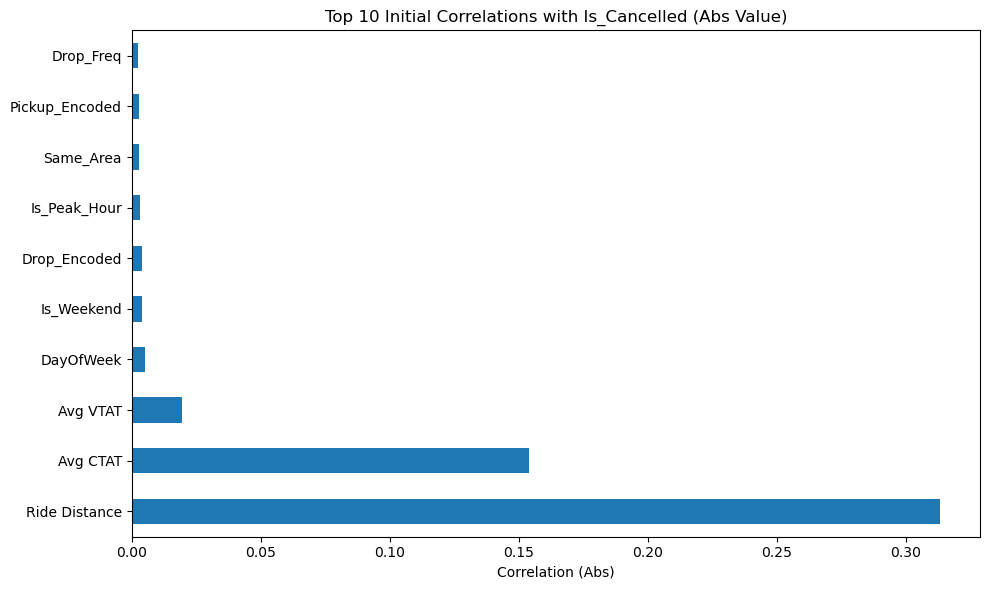

In [9]:
dummy_cols = [col for col in df.columns if col.startswith(('Pickup_', 'Drop_'))]
if dummy_cols:
    dummy_corr = df[dummy_cols].corrwith(df['Is_Cancelled']).sort_values(ascending=False)
    print("\nInitial Correlations with Top Location Dummies (Top 10):")
    print(dummy_corr.round(3).head(10))

plt.figure(figsize=(10, 6))
top_corr_initial = target_corr_initial.abs().sort_values(ascending=False).head(10)
top_corr_initial.plot(kind='barh')
plt.title('Top 10 Initial Correlations with Is_Cancelled (Abs Value)')
plt.xlabel('Correlation (Abs)')
plt.tight_layout()
plt.show()

In [10]:
allowed_status = [
    "Cancelled by Customer",
    "Completed",
    "Cancelled by Driver",
    "Incomplete",
    "No Driver Found"
]

print("Before filter:", df.shape)
print(df["Booking Status"].value_counts(dropna=False).head(20))

df = df[df["Booking Status"].isin(allowed_status)].copy()

print("\nAfter filter:", df.shape)
print(df["Booking Status"].value_counts(dropna=False))

Before filter: (150000, 53)
Booking Status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64

After filter: (150000, 53)
Booking Status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64


In [11]:
y = (df["Booking Status"] == "Cancelled by Customer").astype(int)

print("y distribution:")
print(y.value_counts())
print("positive rate:", y.mean())

y distribution:
Booking Status
0    139500
1     10500
Name: count, dtype: int64
positive rate: 0.07


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    precision_recall_curve
)
from xgboost import XGBClassifier

# ---- Feature set (keep it simple & strong)
feature_cols = [
    "Avg VTAT", "Avg CTAT",
    "Hour", "Weekday", "Is_Weekend", "Is_Peak",
    "Pickup_Freq", "Drop_Freq", "Pickup_Encoded", "Drop_Encoded",
    "Same_Area"
]
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].copy()

# Safety: drop rows with any remaining NA in X or y
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y2 = y[mask]

print("Final X shape:", X.shape)
print("Positive rate:", y2.mean())

# 7:3 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y2, test_size=0.3, random_state=42, stratify=y2
)

# ---- XGBoost model (baseline strong settings)
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

# ---- Probabilities + AUC metrics
y_prob = xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("ROC-AUC:", roc_auc)
print("PR-AUC :", pr_auc)

# Default threshold 0.5
y_pred = (y_prob >= 0.5).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Final X shape: (150000, 9)
Positive rate: 0.07
ROC-AUC: 0.9649415637860081
PR-AUC : 0.7605349183490406

Confusion Matrix:
 [[41823    27]
 [ 1492  1658]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     41850
           1       0.98      0.53      0.69      3150

    accuracy                           0.97     45000
   macro avg       0.97      0.76      0.83     45000
weighted avg       0.97      0.97      0.96     45000

